# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.axes as Axes
from scipy.optimize import minimize
#from scipy.optimize import NonlinearConstraint

%matplotlib inline
import time
import pylab as pl
from IPython import display

# Parameters

In [2]:
config = {"l": 1,
         "mp": 0.2,
         "Mc": 1,
         "g": 9.81,
         "dt":0.09,
         "Np": 18,
         "cart" : (0.6,0.2),
         "iters" : 110,
         "q11": 12.,
         "q22": 0.09,
         "q33": 1.,
         "q44": 0.1,
         "R" : 0.3}

Np=config["Np"]
bound_u=(-3.,3.)
bound =((bound_u,)*Np)

curr_q = np.array([0., 0., -np.random.randn(1)[0], 0.])
curr_q = np.reshape(curr_q,[4,1])
u = np.array(np.ones(Np))



# Helper functions

In [3]:
def state(curr_q,u,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    
    #state x
    dq1 = curr_q[1]  # initial state of the cartpole
    # state xdot
    dq2 = (u+mp*np.sin(curr_q[2])*(l*(curr_q[3]**2)
                                          +g*np.cos(curr_q[2])))/(Mc+mp*(np.sin(curr_q[2])**2))
    # state theta
    dq3 = curr_q[3]
    # state thetadot
    dq4 = (-u*np.cos(curr_q[2])-mp*l*(curr_q[3]**2)
               *np.cos(curr_q[2])*np.sin(curr_q[2])
               -(Mc+mp)*g*np.sin(curr_q[2]))/(l*(Mc+mp*
                                                (np.sin(curr_q[2])**2)))
    next_q = curr_q+np.array([dq1,dq2,dq3,dq4])*dt
    return next_q

In [4]:
def cost_fn(u,curr_q,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    Np= config["Np"]
    R = config["R"]
    cost=0
    q_ref = np.array([0., 0., np.pi, 0.])
    Q = np.array([[config["q11"], 0., 0.,  0.],
        [0., config["q22"], 0., 0.],
        [0., 0., config["q33"], 0.],
        [0., 0., 0., config["q44"]]])
    diff = np.zeros_like(q_ref)
    for i in range(Np):

        next_q = state(curr_q,u[i], config)
        diff[0] = curr_q[0] - q_ref[0]
        diff[1] = curr_q[1] - q_ref[1]
        diff[2] = curr_q[2] - q_ref[2]
        diff[3] = curr_q[3] - q_ref[3]

        iter_cost = np.matmul(np.matmul(diff.T,Q),diff) + R*((u[i]-0.)**2)
        cost += iter_cost
        curr_q = next_q
    return cost

In [5]:
max_iter = config["iters"]
history_q = []
history_u = []
p=0.2
for i in range(max_iter):
    #if i>int(0.8*max_iter) and np.random.random(1)<p:
    #curr_q[2] += np.random.randn(1)[0]
    history_q.append(curr_q)
    cost=cost_fn(u,curr_q,config)
    out=minimize(cost_fn,u,(curr_q,config), method='L-BFGS-B', bounds=bound,
                 options={'disp': False})


    u=out.x
    history_u.append(u[0])
    curr_q= state(curr_q,u[0], config)


# Helper Functions for display

In [6]:
def rotate_pos(pos, angle):

    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    #print(np.shape(np.dot(pos, rot_mat.T)))
    return np.dot(pos, rot_mat.T)

def square(center_x, center_y, shape, angle):

    #square_xy = np.array([shape[0], shape[1]])
    square_xy = np.array([[shape[0], shape[1]],
                              [-shape[0], shape[1]],
                              [-shape[0], -shape[1]],
                              [shape[0], -shape[1]],
                              [shape[0], shape[1]]])
    # translate position to world
    # rotation
    trans_points = rotate_pos(square_xy, angle)
    #print([center_x[0], center_y])
    #print(trans_points)
    # translation
    trans_points += [center_x[0], center_y]

    return trans_points[:,0], trans_points[:,1]

def coord_cartpole(curr_q,config):

    cart=config["cart"]
    l=config["l"]
    #cart
    cart_x,cart_y = square(curr_q[0], 0., cart, 0.)
    #pend
    pend_x = np.array([curr_q[0], curr_q[0]+l*np.cos(curr_q[2]-np.pi/2)])
    pend_y = np.array([0., l*np.sin(curr_q[2]-np.pi/2)])
    return cart_x,cart_y, pend_x, pend_y




# Visualization Cartpole

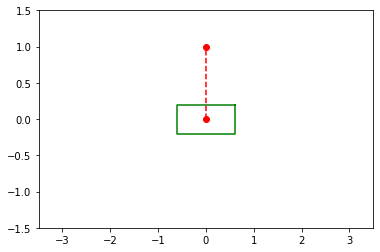

In [7]:

for i in range(max_iter):
    curr_x = history_q[i]
    x1,y1, x2, y2 = coord_cartpole(curr_x,config)
    pl.clf()
    pl.plot(x1, y1, 'g-',x2, y2, 'r--o')
    pl.xlim(-3.5, 3.5)
    pl.ylim(-1.5,1.5)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)

# Visualization states and input

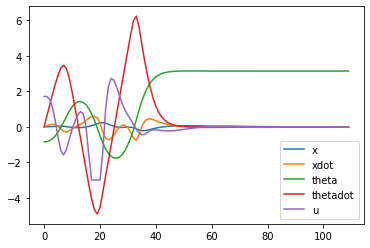

In [8]:
x=[]
xdot=[]
th=[]
thdot=[]
for i in range(max_iter):
    x.append(history_q[i][0])
    xdot.append(history_q[i][1])
    th.append(history_q[i][2])
    thdot.append(history_q[i][3])
 

plt.plot(x)
plt.plot(xdot)
plt.plot(th)
plt.plot(thdot)
plt.plot(history_u)
plt.legend(['x','xdot','theta','thetadot','u'])